# Some quality control metrics for ontogeny depth videos

In [1]:
import av
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from toolz import concat
from tqdm.auto import tqdm
from toolz import take
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
folders = [
    '/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_females',
    '/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_males',
    '/n/groups/datta/Dana/Ontogeny/raw_data/longtogeny_pre_unet/Females',
    '/n/groups/datta/Dana/Ontogeny/raw_data/longtogeny_pre_unet/Males',
    '/n/groups/datta/min/dominance_v1',
    '/n/groups/datta/min/community_v1',
    '/n/groups/datta/min/wheel_062023',
    '/n/groups/datta/min/cas_behavior_01',
]
folders = [Path(f) for f in folders]

In [3]:
files = list(concat(f.glob('**/results_00.h5') for f in folders))

## QC's

1. find sessions where no mouse is found in a significant number of frames
2. find sessions where there's a lot of noise surrounding the mouse
3. find sessions where the bucket moved within session

In [4]:
threshold = 10
percentage_threshold = 0.05

flag_df_path = Path('/n/groups/datta/win/longtogeny/data/metadata/flag_dataframe.parquet')

## QC 1+2

In [5]:
def compute_stats(file):
    try:
        with h5py.File(file, 'r') as h5f:
            frames = h5f['frames'][()]
            good_frames = (frames > threshold).sum(axis=(1, 2))
            bad_frames = good_frames < 150

            # QC 2
            mask = ~(np.median(frames, axis=0, keepdims=True) > 5)
            masked_frames = frames * mask

            noisy_frames = (masked_frames > 9).sum(axis=(1, 2))
            has_noise = noisy_frames > 500
            high_noise = noisy_frames > 900

        return dict(
            path=str(file),
            no_mouse_frames=bad_frames.mean(),
            noisy_frames=has_noise.mean(),
            very_noisy_frames=high_noise.mean(),
        )
    except OSError:
        return dict(
            path=str(file),
            no_mouse_frames=0,
            noisy_frames=0,
            very_noisy_frames=0,
        )

In [6]:
flagged_sessions = []
if flag_df_path.exists():
    flag_df = pd.read_parquet(flag_df_path)
else:
    flag_df = pd.DataFrame(dict(path=[], no_mouse_frames=[], noisy_frames=[])).astype(
        dict(no_mouse_frames=int, noisy_frames=int)
    )

_options = []

with open(
    "/n/groups/datta/win/longtogeny/data/metadata/flagged_sessions.txt", "r+"
) as md:
    flagged_sessions = md.readlines()
    pbar = tqdm(range(len(files)))
    pbar.update(len(flag_df))
    try:
        with ThreadPoolExecutor(max_workers=3) as pool:
            futures = [
                pool.submit(compute_stats, f)
                for f in filter(lambda f: str(f) not in flag_df["path"].values, files)
            ]

            for future in as_completed(futures):
                res = future.result()
                _options.append(res)

                if (
                    res["no_mouse_frames"] > percentage_threshold
                    or res["noisy_frames"] > percentage_threshold
                ):
                    flagged_sessions.append(res["path"])
                    md.write(res["path"] + "\n")
                    print(len(flagged_sessions), end="\r")
                pbar.update(1)
    except KeyboardInterrupt:
        pass
    finally:
        flag_df = pd.concat([flag_df, pd.DataFrame(_options)], ignore_index=True)
        flag_df.to_parquet(flag_df_path)

  0%|          | 0/3733 [00:00<?, ?it/s]

## QC 3: find sessions where the bucket has been moved during the session

In [4]:
files = list(concat(f.glob('**/depth.*') for f in folders))

In [ ]:
n_frames = 150

with open(
    "/n/groups/datta/win/longtogeny/data/metadata/moved_bucket_sessions.txt", "w"
) as md:
    for f in tqdm(files):
        try:
            if f.name.endswith("avi"):
                with av.open(str(f), "r") as reader:
                    vid = reader.streams.video[0]
                    vid.thread_type = "AUTO"
                    rate = vid.average_rate
                    start = vid.start_time
                    time_base = vid.time_base
                    first_frames = []
                    for frame in map(
                        lambda v: v.to_ndarray(), take(n_frames, reader.decode(video=0))
                    ):
                        first_frames.append(frame)
                    # grab first N frames
                    start_frame = vid.frames - n_frames
                    target_pts = int(start_frame / rate / time_base) + start
                    reader.seek(target_pts, stream=vid)
                    # grab last N frames
                    last_frames = []
                    for frame in map(
                        lambda v: v.to_ndarray(), take(n_frames, reader.decode(video=0))
                    ):
                        last_frames.append(frame)
                    diff = np.abs(
                        (
                            np.median(first_frames, axis=0)
                            - np.median(last_frames, axis=0)
                        )
                    )
                    if (diff > 50).sum() > 8000:
                        print("Flagged session", str(f))
                        md.write(str(f) + "\n")
            elif f.name.endswith("dat"):
                pass
        except PermissionError:
            continue

## Round 2 of filtering for flagged sessions from QC 1+2

In [29]:
with open('/n/groups/datta/win/longtogeny/data/metadata/flagged_sessions.txt', 'r') as md:
    flagged_files = [l.strip() for l in md.readlines()]

In [47]:
flags = []
for f in tqdm(flagged_files):
    with h5py.File(f, 'r') as h5f:
        # QC 1
        frames = h5f['frames'][()]
        mask = ~(np.median(frames, axis=0, keepdims=True) > 5)
        good_frames = (frames > threshold).sum(axis=(1, 2))
        bad_frames = good_frames < 150
        no_mouse = bad_frames.mean() > percentage_threshold

        _flags = [f]
        if no_mouse:
            _flags.append("no mouse")

        # QC 2
        masked_frames = frames * mask
        noisy_frames = (masked_frames > 9).sum(axis=(1, 2))
        noise = (noisy_frames > 500).mean() > percentage_threshold
        if noise:
            _flags.append("noise")

        if len(_flags) > 1:
            flags.append(_flags)
            print(len(flags), end='\r')

  0%|          | 0/623 [00:00<?, ?it/s]

In [74]:
flags[0]

['/n/groups/datta/Dana/Ontogeny/raw_data/Ontogeny_females/18months/session_20221013141139/proc/results_00.h5',
 'noise']

In [46]:
(noisy_frames > 500).mean()

0.01651223128243143

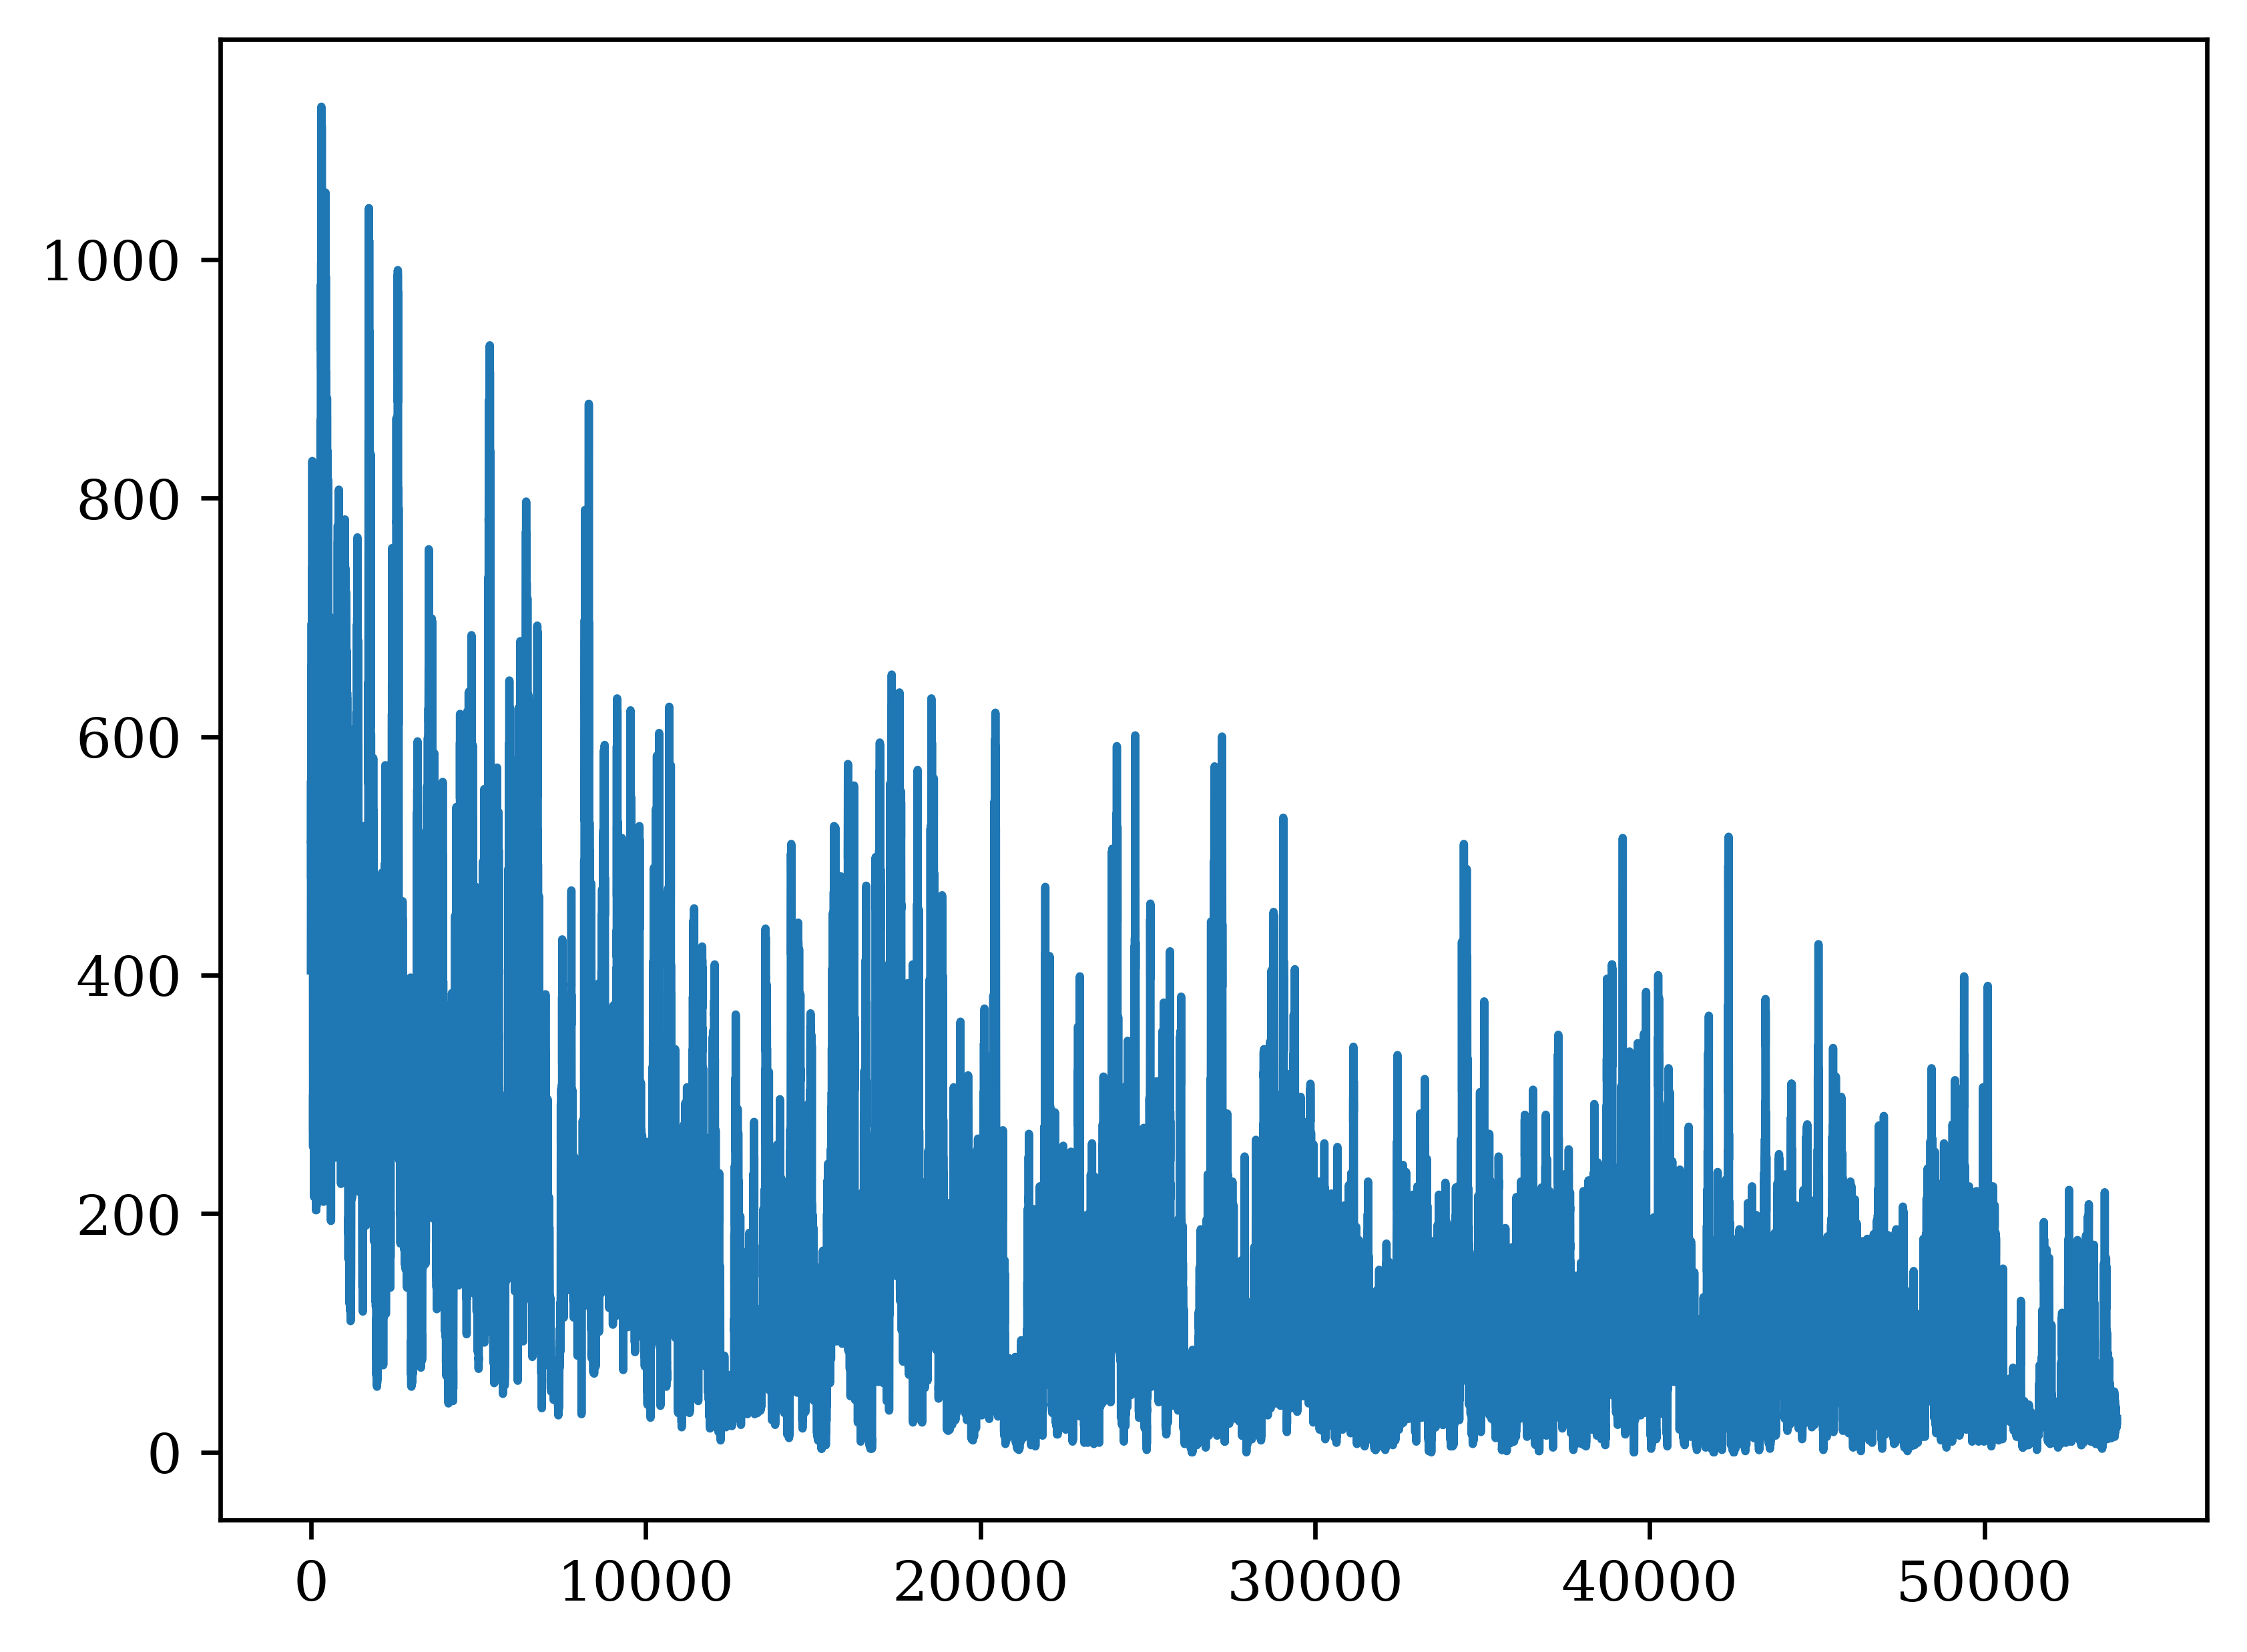

In [38]:
plt.plot(noisy_frames)

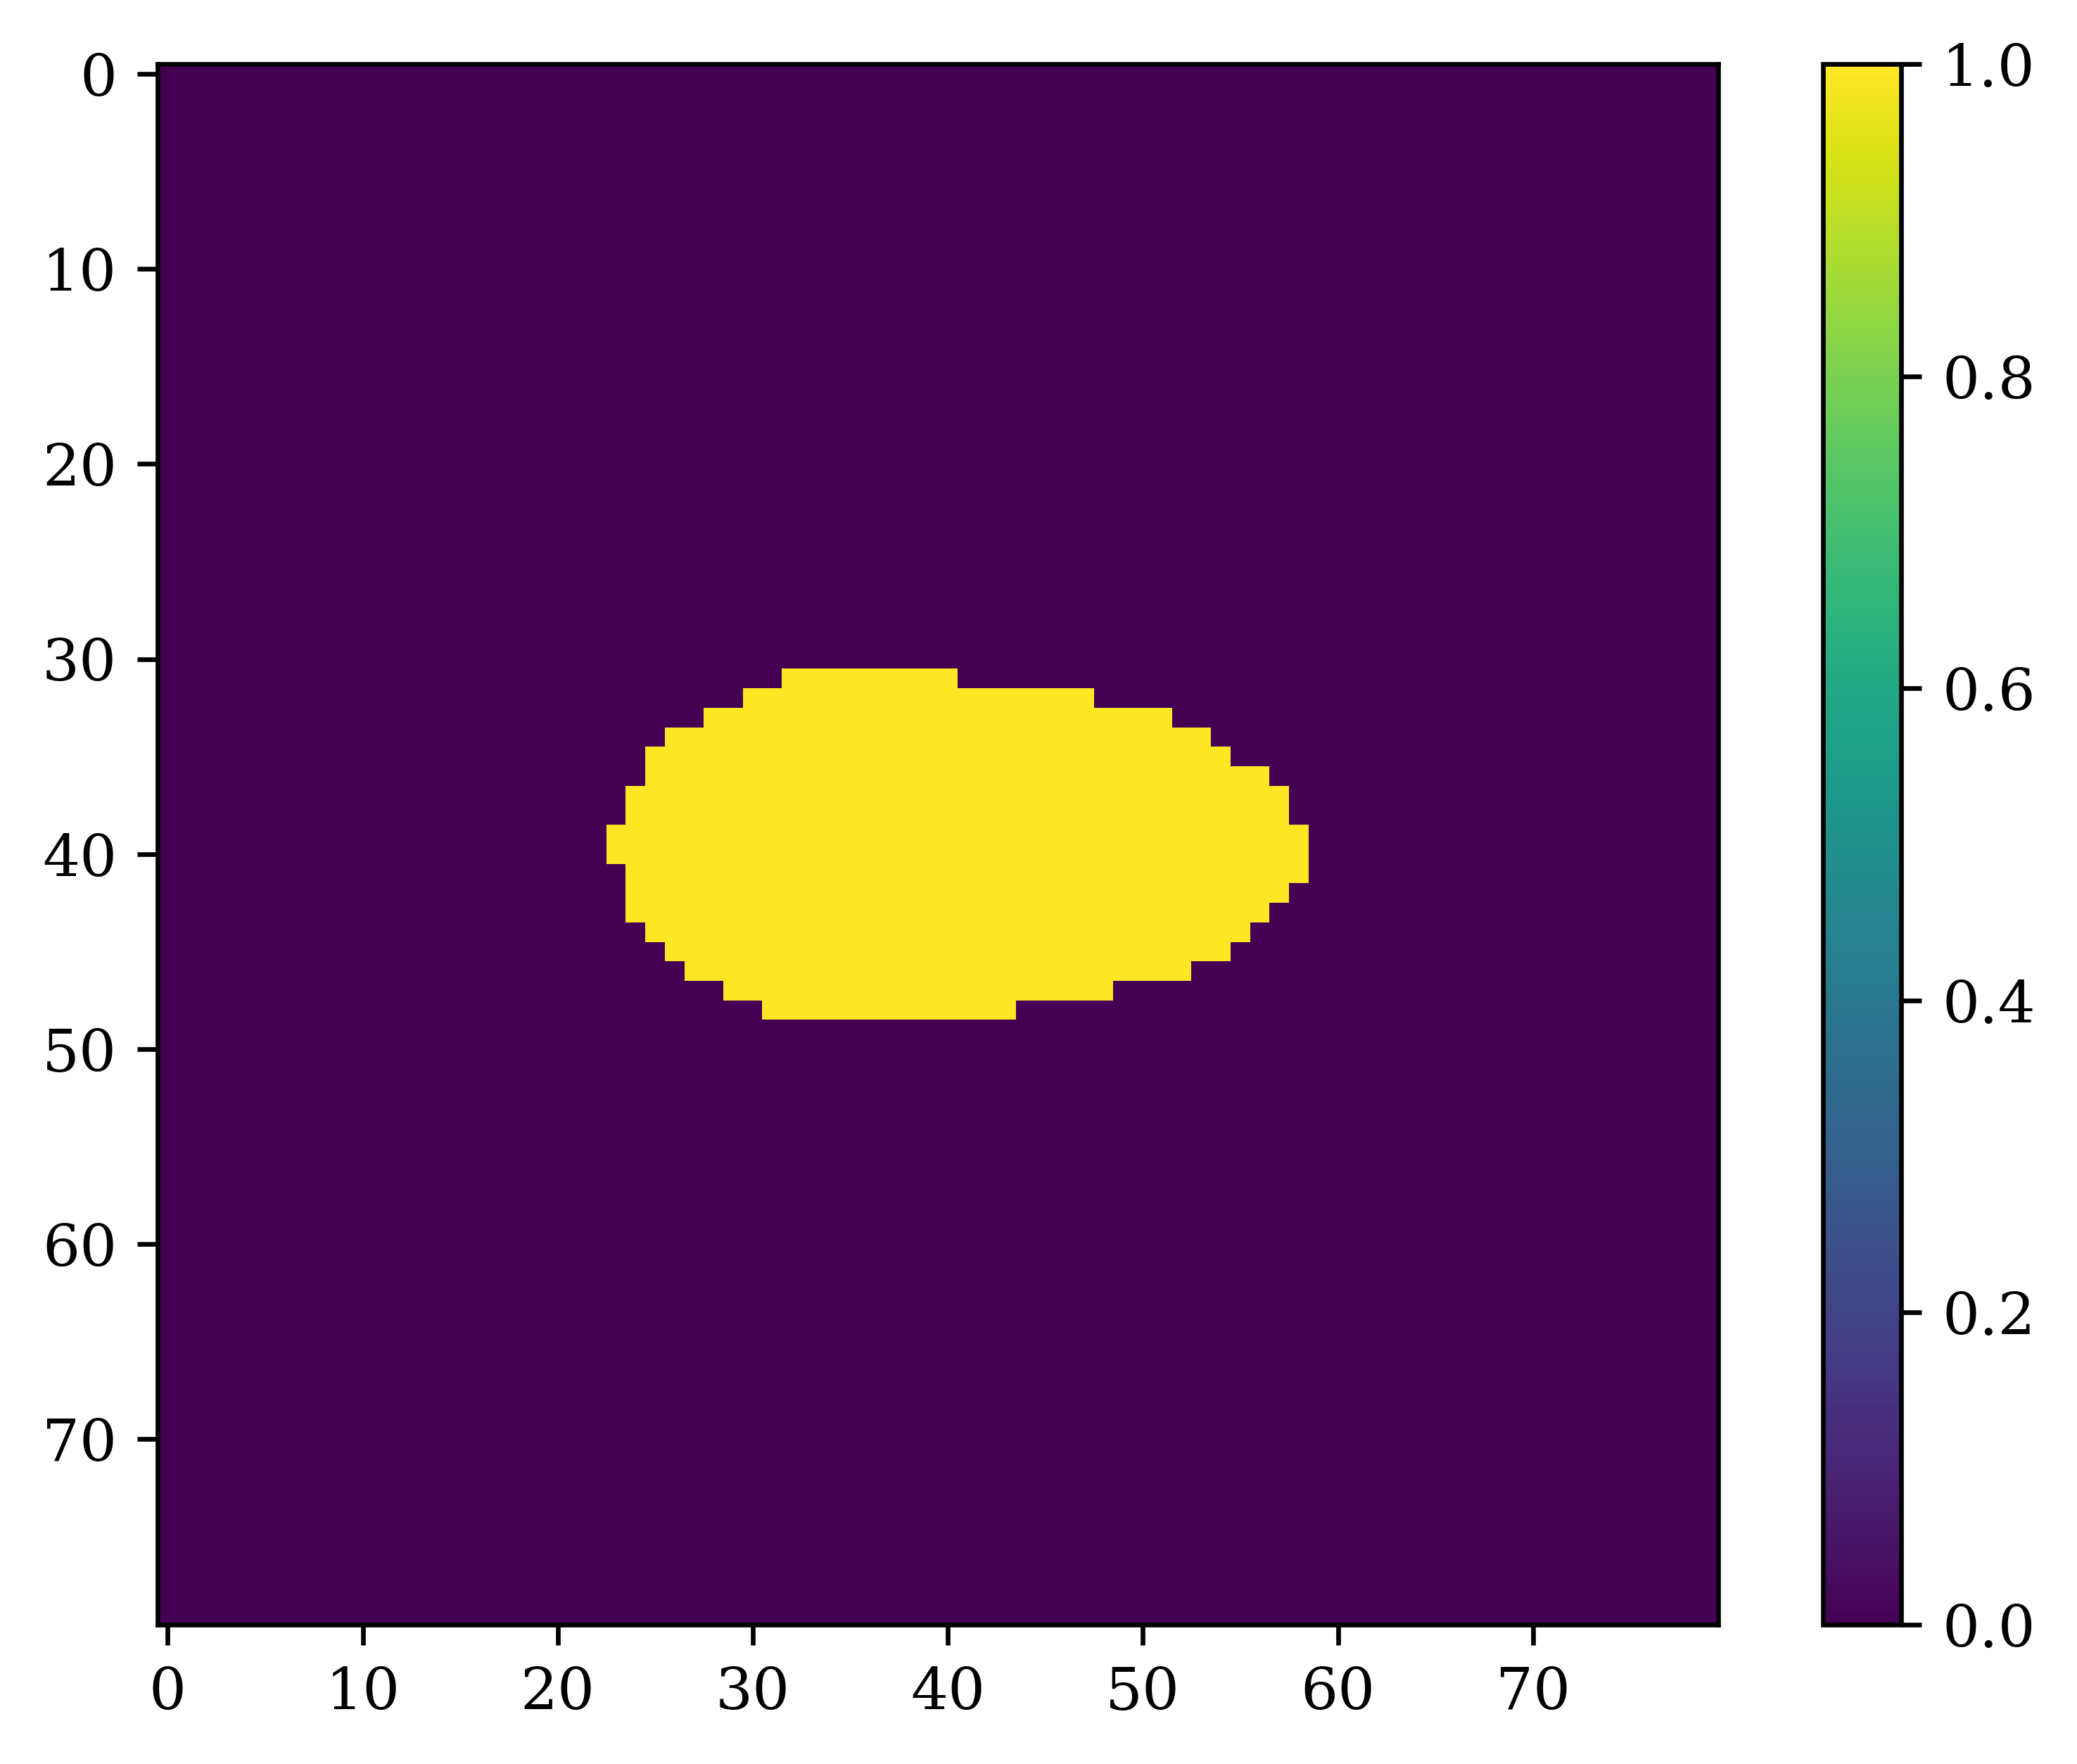

In [34]:
plt.imshow(mask[0])
plt.colorbar()

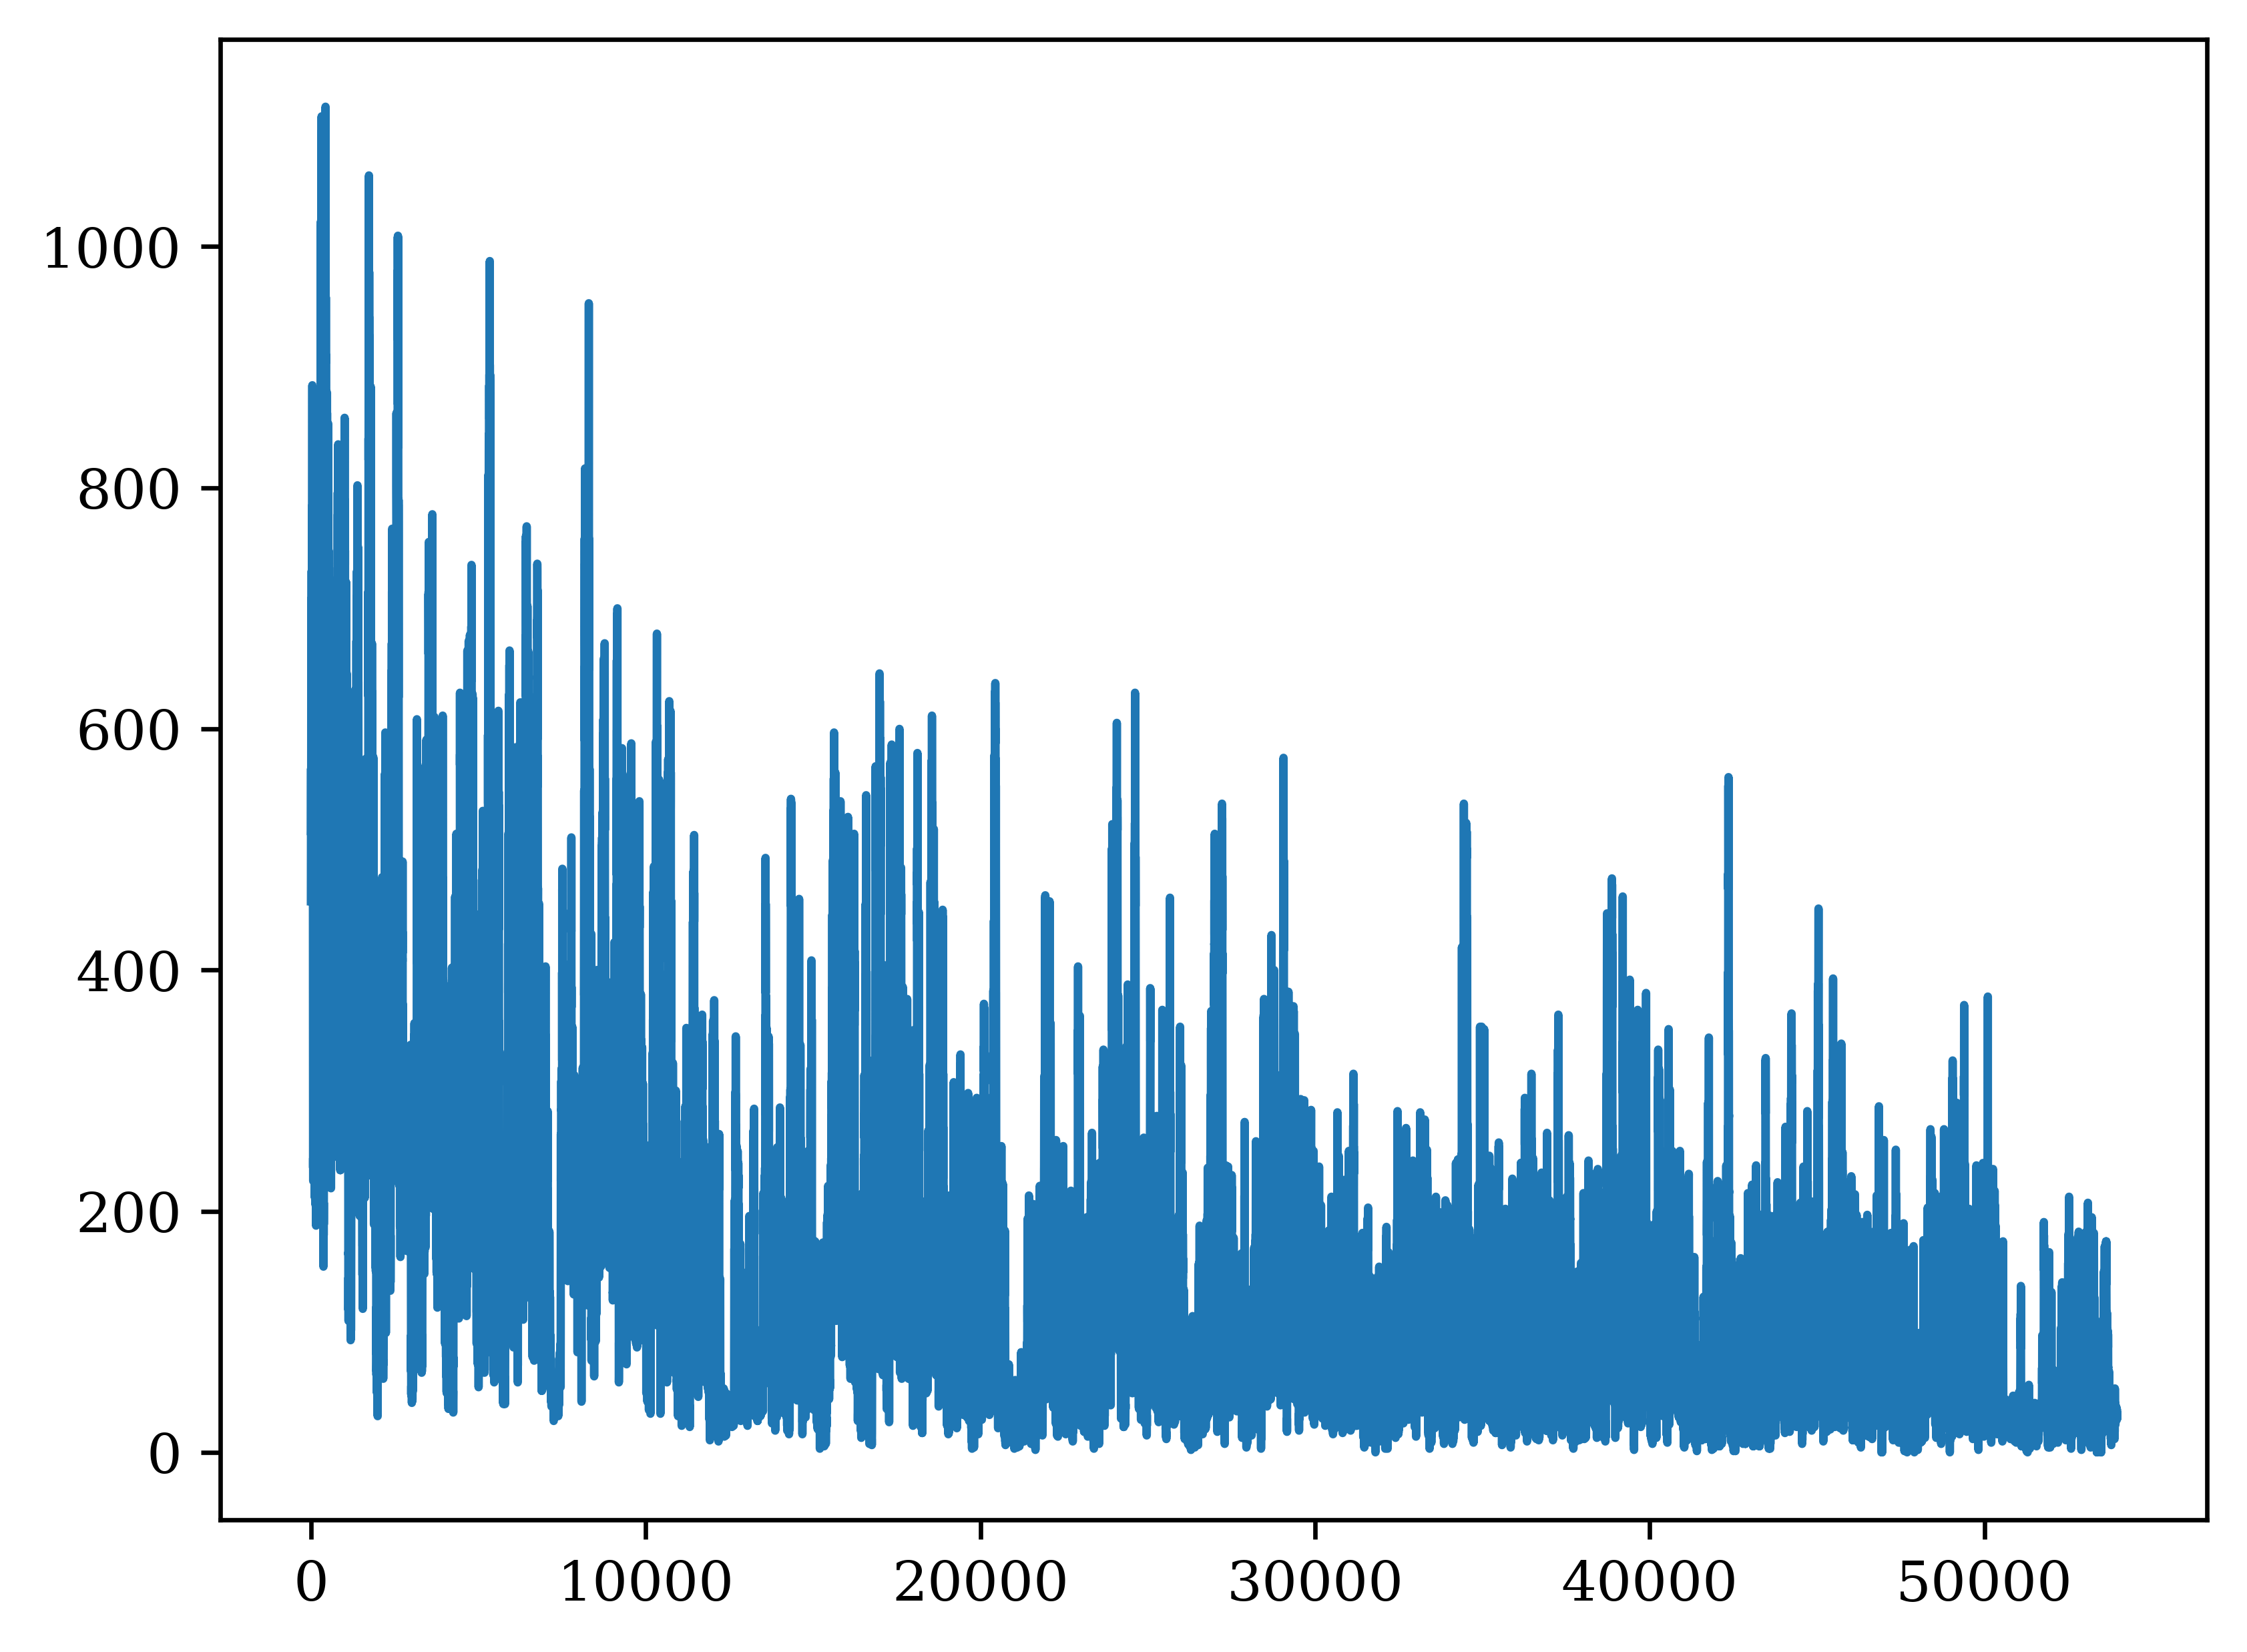

In [28]:
plt.plot(noisy_frames)

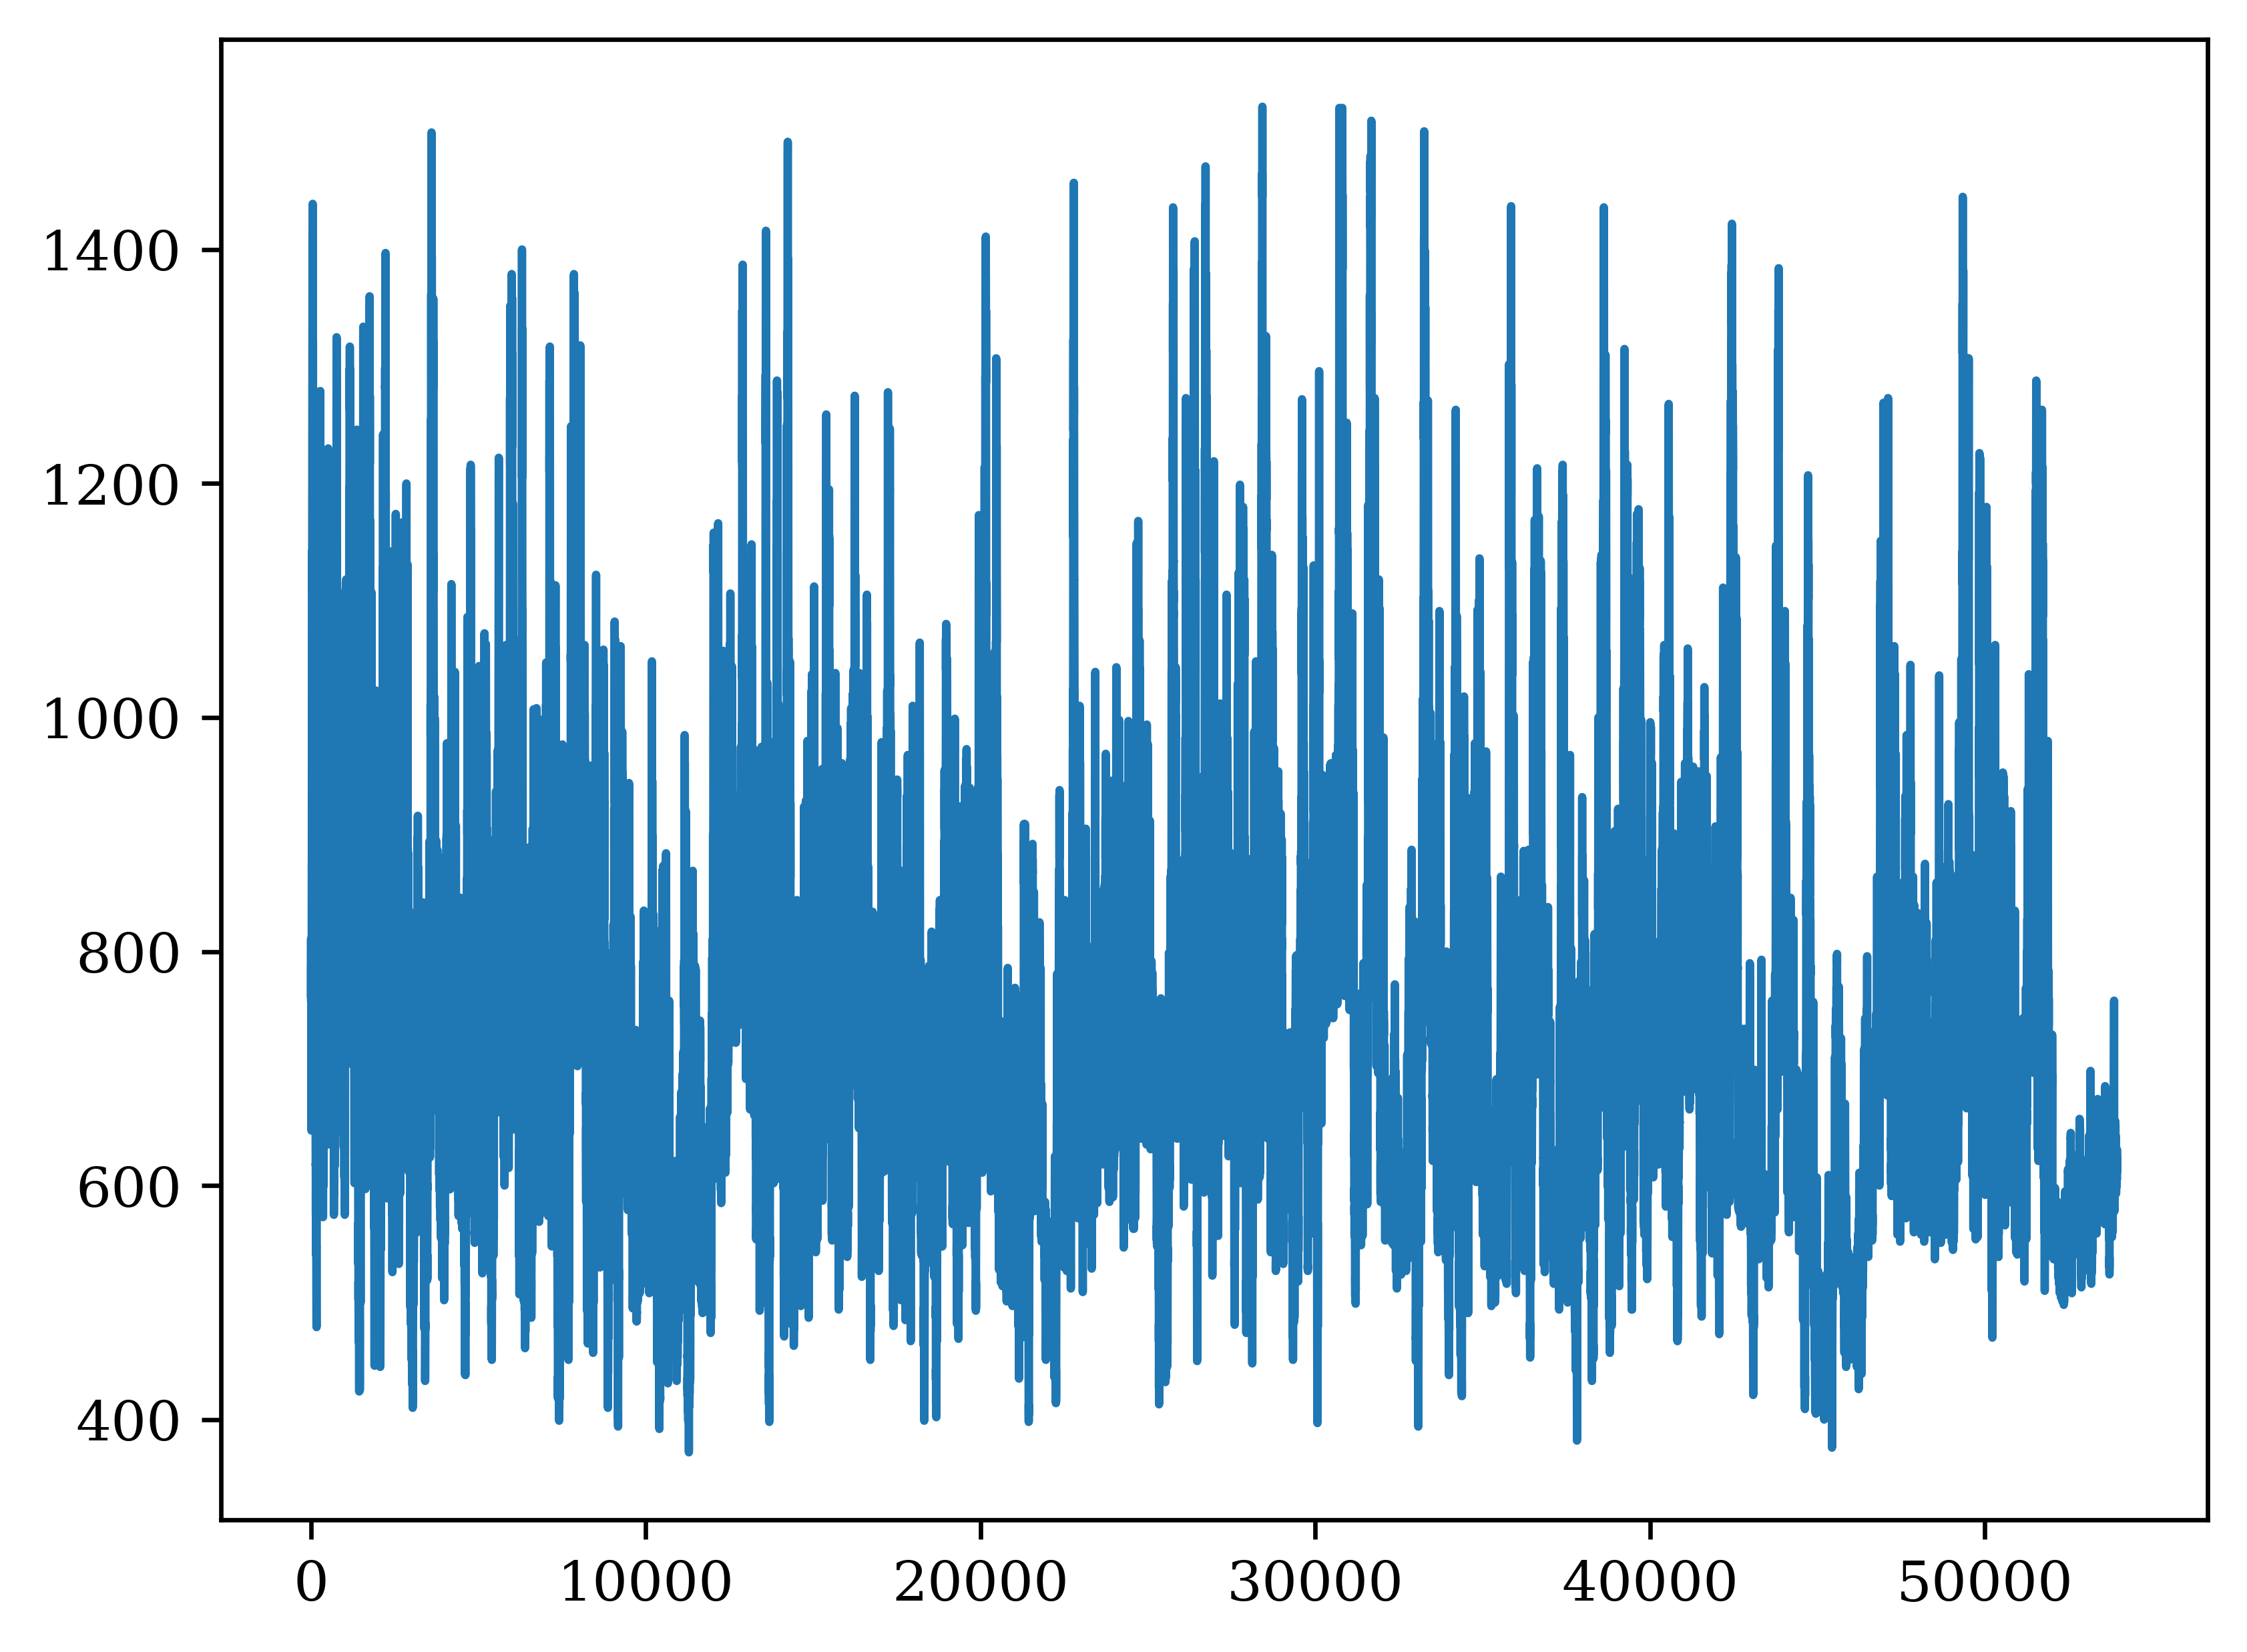

In [22]:
plt.plot(good_frames)